In [2]:
import os

import json
import torch

from datetime import datetime
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR
import turkish_tokenizer as tt

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Tokenizer'ı başlat

tr_tokenizer = tt.TurkishTokenizer()
print(tt.__version__)
print(device)

0.2.13
mps


In [30]:
from gemma_claude import create_gemma3_model

model_claude = create_gemma3_model(vocab_size=32768)

model_save_path = "model_2.pth"
# check if saved model exists
if os.path.exists(model_save_path):
    model_claude.load_state_dict(torch.load(model_save_path))
    print("loaded model from", model_save_path)
else:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    from tokenizer_matcher import TokenizerMatcher

    gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-270m-it")
    gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-3-270m-it")
    model_state = gemma_model.state_dict()
    model_state.pop('lm_head.weight')
    model_state.pop('model.embed_tokens.weight')
    model_claude.load_state_dict(model_state, strict=False)
    print("loaded model from gemma model")

    tokenizer_matcher = TokenizerMatcher(
        source_tokenizer=gemma_tokenizer,
        target_tokenizer=tr_tokenizer,
        source_model=gemma_model,
        target_model=model_claude
    )

    matched_embeddings = tokenizer_matcher.match_embeddings(adding_style="sum")
    tokenizer_matcher.change_target_model_embeddings(matched_embeddings)
    print("matched embeddings")
    # save claude model using torch 
    torch.save(model_claude.state_dict(), model_save_path)
    print("saved model to", model_save_path)

model_claude = model_claude.to(device)
model_claude

loaded model from model_2.pth


Gemma3ForCausalLM(
  (model): Gemma3Model(
    (embed_tokens): Gemma3ScaledWordEmbedding(32768, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELU(approximate='tanh')
        )
        (input_layernorm): Gemma3RMSNorm((640,), eps=1

In [3]:
from datasets import load_dataset

# Load the English dataset from the latest dump
ds_wiki = load_dataset("omarkamali/wikipedia-monthly", "20250703.tr", split="train")
# first 100 to text with title
text = ""
for i in range(1000):
    text += ds_wiki[i]["title"] + "\n" + ds_wiki[i]["text"] + "\n"

while "\n " in text:
    text = text.replace("\n ", "\n")

while "\n\n" in text:
    text = text.replace("\n\n", "\n")


with open("data.txt", "w", encoding="utf-8") as f:
    f.write(text)

ds_wiki, len(text)

(Dataset({
     features: ['id', 'url', 'title', 'raw_mediawiki', 'text'],
     num_rows: 641443
 }),
 8246759)

In [3]:
from text_dataset import create_dataset, create_dataloader

with open("data.txt", "r", encoding="utf-8") as f:
    text = f.read()

seq_len = 512
stride = 1
batch_size = 12
shuffle = False

train_dataset = create_dataset(text[:40000], tr_tokenizer, seq_len, stride, device)
# dataset = create_or_load_dataset(text[:50000], tr_tokenizer, seq_len, stride, device, cache_path="dataset/wiki1")
train_dataloader = create_dataloader(train_dataset, batch_size, shuffle)

valid_dataset = create_dataset(text[40000:42000], tr_tokenizer, seq_len, stride, device)
valid_dataloader = create_dataloader(valid_dataset, batch_size, shuffle)

TextDataset: 18471 tokens, seq_len=512, stride=1
Calculated sequences: 17960
TextDataset: 1010 tokens, seq_len=512, stride=1
Calculated sequences: 499


In [32]:
prompt = "Merhaba, nasılsın? "
model_claude.eval()
tr_tokenizer.encode(prompt)
input_ids = torch.tensor(tr_tokenizer.encode(prompt)).unsqueeze(0)
output = model_claude.generate(input_ids)
text = tr_tokenizer.decode(output[0].tolist())
text

'Merhaba, nasılsın? larlabirlik ler  lerpaketpaketyöneticiesahip.indir<uppercase>'

'Merhaba, nasılsın? ,toylar\nili\nüye ler\nüye si larını   lar\n r\nlinx lar dağıt  sısistem ne ler   a'

In [4]:
prompt = "Merhaba, nasılsın? "

@torch.no_grad()
def print_example(model: torch.nn.Module, prompt: str, epoch: int, loss: float):
  model.eval()
  tr_tokenizer.encode(prompt)
  input_ids = torch.tensor(tr_tokenizer.encode(prompt)).unsqueeze(0)
  output = model.generate(input_ids, max_length=10)
  text = tr_tokenizer.decode(output[0].tolist())
  result_dict = {
    "epoch": epoch,
    "loss": loss,
    "text": text,
    "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  }
  if not os.path.exists("epoch_examples.json"):
    with open("epoch_examples.json", "w", encoding="utf-8") as f:
      json.dump([], f, ensure_ascii=False, indent=2)
  with open("epoch_examples.json", "r", encoding="utf-8") as f:
    result_list = json.load(f)
  result_list.append(result_dict)
  with open("epoch_examples.json", "w", encoding="utf-8") as f:
    json.dump(result_list, f, ensure_ascii=False, indent=2)

print_example(model_claude, prompt, 0, 0)

In [5]:
loss_history = []

def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        max_epochs: int = 10,
        gradient_accumulation_steps: int = 2
    ):
    # model = torch.compile(model).to(device)
    model.train()  # Changed from model.compile() to model.train()
    accumulation_loss = 0.0
    min_learning_rate = 1e-6
    learning_rate = 5e-3
    # Calculate total steps across all epochs
    total_steps = len(train_dataloader) * max_epochs
    warmup_steps = max(1, round(total_steps * 0.005))  # ~0.6% warmup; ensure >=1

    # Create optimizer - fixed to use model parameter instead of model_claude
    optimizer = AdamW(
        model.parameters(),
        lr=5e-3,
        weight_decay=0.1
    )

    # create a scheduler
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=max(min_learning_rate / learning_rate, 1e-6),
        end_factor=1.0,
        total_iters=warmup_steps
    )
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=max(1, total_steps - warmup_steps),
        eta_min=min_learning_rate
    )
    global_step = 0

    # print information of optimizer and training parameters
    print(f"Warmup steps: {warmup_steps}")
    print(f"Total steps: {total_steps}")
    print(f"Learning rate: {learning_rate}")
    print(f"Min learning rate: {min_learning_rate}")

    # Single progress bar for all epochs
    progress_bar = tqdm(total=total_steps, desc="Training", leave=True)

    for epoch in range(max_epochs):
        for step, batch in enumerate(train_dataloader):
            input_ids, labels = batch
            # Fixed to use model parameter instead of model_claude
            outputs = model(input_ids, labels=labels)
            loss = outputs['loss'] / gradient_accumulation_steps
            loss.backward()
            accumulation_loss += loss.item()
            loss_history.append(loss.item())
            with open("loss_history.json", "w", encoding="utf-8") as f:
                json.dump(loss_history, f, ensure_ascii=False, indent=2)
            
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

                # drive exactly one scheduler, without epoch arguments
                if global_step < warmup_steps:
                    warmup_scheduler.step()
                else:
                    cosine_scheduler.step()

                global_step += 1

                progress_bar.set_postfix({
                    "Epoch": f"{epoch + 1}/{max_epochs}",
                    "Step": f"{step + 1}/{len(train_dataloader)}",
                    "Loss": f"{accumulation_loss:.4f}",
                    "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
                })
                accumulation_loss = 0.0
            
            progress_bar.update(1)

            if step % 250 == 0:
                print_example(model, prompt, epoch, accumulation_loss)
        # save model
        torch.save(model.state_dict(), f"model_{epoch}.pth")
        model.train()

    progress_bar.close()
    print("Done")

train(model_claude, train_dataloader)

Warmup steps: 75
Total steps: 14970
Learning rate: 0.005
Min learning rate: 1e-06


Training:  60%|██████    | 8995/14970 [6:18:55<6:14:09,  3.76s/it, Epoch=7/10, Step=12/1497, Loss=10.3049, LR=0.003991]   

KeyboardInterrupt: 

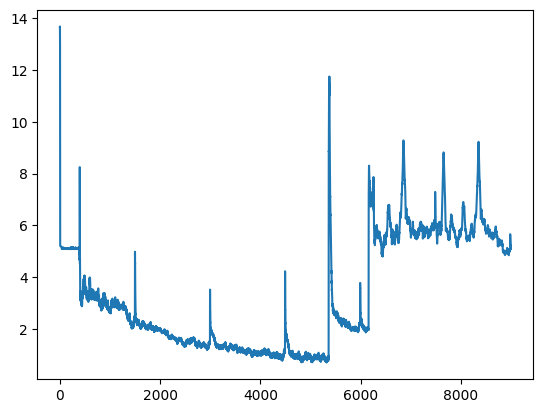

In [6]:
# plot loss history
import matplotlib.pyplot as plt
import json

with open("loss_history.json", "r", encoding="utf-8") as f:
    loss_history = json.load(f)

plt.plot(loss_history)
plt.show()